In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

##Load the data and create testing, validation, and training dataframes

We'll use the smaller clean dataframe we've already created elsewhere.  Every included climb and user has at least 50 ratings in this dataframe.  This high cutoff was in part to improve support, but also - and more importantly - to reduce the size of the data we are working with to something more reasonable.

In [3]:
fulldf = pd.read_csv('classifier_dfs/finalproject-joined-cleaned-small-df.csv')

In [4]:
fulldf.head()

,Unnamed: 0,climb_id,user_id,star_rating,tick_date,ticked,sugg_aid_grade,sugg_boulder_grade,sugg_ice_grade,sugg_mixed_grade,sugg_rock_grade,sugg_ice_grade_number,sugg_boulder_grade_number,sugg_aid_grade_number,sugg_mixed_grade_number,sugg_rock_grade_number,location_state,climbs_trad,gender,age,climbs_aid,climbs_ice,climbs_boulder,user_link,climbs_mixed,location_place,climbs_sport,member_date,user_name,lead_diff_sport,boulder_diff,follow_diff_sport,lead_diff_ice,lead_diff_trad,follow_diff_ice,follow_diff_trad,follow_diff_mixed,lead_diff_mixed,follow_diff_aid,lead_diff_aid,lead_diff_sport_number,follow_diff_aid_number,lead_diff_ice_number,follow_diff_sport_number,follow_diff_mixed_number,lead_diff_aid_number,lead_diff_mixed_number,lead_diff_trad_number,boulder_diff_number,follow_diff_ice_number,...,user_zip_code,user_place,climb_name,climb_link,fa_year,feet,page_views,pitches,avg_stars,area_0,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,"type_TR,",type_aid,type_alpine,type_boulder,type_ice,type_mixed,type_sport,type_trad,guide_aid_grade,guide_boulder_grade,guide_ice_grade,guide_mixed_grade,guide_rock_grade,concensus_aid_grade,concensus_boulder_grade,concensus_ice_grade,concensus_mixed_grade,concensus_rock_grade,guide_aid_grade_number,guide_rock_grade_number,guide_boulder_grade_number,concensus_rock_grade_number,concensus_boulder_grade_number,concensus_ice_grade_number,guide_ice_grade_number,concensus_mixed_grade_number,guide_mixed_grade_number,concensus_aid_grade_number,state,latitude,longitude
0,1408,105717289,105990845,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,0,https://www.mountainproject.com/u/orphaned//10...,0,NaN,0,"(2007, 7, 9, 0, 0, 0, 0, 190, -1)",orphaned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,kor-ingalls-route,http://www.mountainproject.com/v/kor-ingalls-r...,1961,NaN,70344,4,3.3619,/destinations/,/v/utah/105708957,/v/moab-area/105716711,/v/castle-valley/105716784,/v/castleton-tower/105716850,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,0,0,0,5.9,0,0,0,0,5.9+,NaN,9,NaN,9.3,NaN,NaN,NaN,NaN,NaN,NaN,Utah,38.651,-109.3678
1,1416,105717289,106192059,3,"time.struct_time(tm_year=2011, tm_mon=3, tm_md...",1,NaN,NaN,NaN,NaN,5.9+,NaN,NaN,NaN,NaN,9.3,CO,1,0,40,0,0,1,https://www.mountainproject.com/u/julius-beres...,0,Boulder,1,"(2008, 6, 27, 0, 0, 0, 4, 179, -1)",julius-beres,5.12b,V6,5.12c,NaN,5.11b,NaN,5.11c,NaN,NaN,NaN,NaN,14.5,NaN,NaN,15,NaN,NaN,NaN,12.5,6,NaN,...,NaN,Boulder,kor-ingalls-route,http://www.mountainproject.com/v/kor-ingalls-r...,1961,NaN,70344,4,3.3619,/destinations/,/v/utah/105708957,/v/moab-area/105716711,/v/castle-valley/105716784,/v/castleton-tower/105716850,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,0,0,0,5.9,0,0,0,0,5.9+,NaN,9,NaN,9.3,NaN,NaN,NaN,NaN,NaN,NaN,Utah,38.651,-109.3678
2,1419,105717289,10232,4,NaN,NaN,NaN,NaN,NaN,NaN,5.9+,NaN,NaN,NaN,NaN,9.3,CO,1,0,NaN,0,0,0,https://www.mountainproject.com/u/tony-b//10232,0,Around Boulder,1,"(2001, 1, 1, 0, 0, 0, 0, 1, -1)",tony-b,5.11c,NaN,5.11c,NaN,5.11c,NaN,5.11c,NaN,NaN,NaN,NaN,13.0,NaN,NaN,13,NaN,NaN,NaN,13.0,NaN,NaN,...,NaN,Around Boulder,kor-ingalls-route,http://www.mountainproject.com/v/kor-ingalls-r...,1961,NaN,70344,4,3.3619,/destinations/,/v/utah/105708957,/v/moab-area/105716711,/v/castle-valley/105716784,/v/castleton-tower/105716850,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,0,0,0,5.9,0,0,0,0,5.9+,NaN,9,NaN,9.3,NaN,NaN,NaN,NaN,NaN,NaN,Utah,38.651,-109.3678
3,1424,105717289,105942841,NaN,"time.struct_time(tm_year=2009, tm_mon=3, tm_md...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CO,1,0,32,0,0,0,https://www.mountainproject.com/u/tootalltim//...,0,Boulder,0,"(2007, 4, 9, 0, 0, 0, 0, 99, -1)",tootalltim,NaN,NaN,NaN,NaN,5.10a,NaN,5.11c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,...,NaN,Boulder,kor-ingalls-route,http://www.mountainproject.com/v/kor-ingalls-r...,1961,NaN,70344,4,3.3619,/destinations/,/v/utah/105708957,/v/moab-area/105716711,/v/castle-valley/1

We cut out the columns we're not going to need, and any nan ratings.

In [5]:
fulldf = fulldf[['climb_id','user_id','star_rating']]

In [7]:
mask = [False if str(x) == 'nan' else True for x in fulldf.star_rating]
fulldf = fulldf[mask]

In [8]:
fulldf.head()

,climb_id,user_id,star_rating
0,105717289,105990845,4
1,105717289,106192059,3
2,105717289,10232,4
4,105717289,10431,4
5,105717289,107356939,4


We randomly split the data.

In [9]:
rand_split = [1 if x < .7 else 2 if x < .85 else 3 for x in list(np.random.random(len(fulldf)))]
train_split = [True if x == 1 else False for x in rand_split]
validate_split = [True if x == 2 else False for x in rand_split]
test_split = [True if x == 3 else False for x in rand_split]

In [10]:
traindf = fulldf[train_split]
validatedf = fulldf[validate_split]
testdf = fulldf[test_split]

In [11]:
len(traindf), len(validatedf), len(testdf)

(15537, 3306, 3374)

And do a few checks to make sure every climb and user is well represented in the training set.

In [12]:
trainUsers = np.unique(traindf.user_id)
trainClimbs = np.unique(traindf.climb_id)
validateUsers = np.unique(validatedf.user_id)
validateClimbs = np.unique(validatedf.climb_id)
testUsers = np.unique(testdf.user_id)
testClimbs = np.unique(testdf.climb_id)

In [13]:
print [user for user in validateUsers if user not in trainUsers]
print [climb for climb in validateClimbs if climb not in trainClimbs]
print [user for user in testUsers if user not in trainUsers]
print [climb for climb in testClimbs if climb not in trainClimbs]

[]
[]
[]
[]


In [14]:
print sorted(traindf.groupby('user_id').count().star_rating)[:10]
print sorted(traindf.groupby('climb_id').count().star_rating)[:10]

[30, 31, 33, 33, 34, 34, 35, 35, 35, 35]
[29, 29, 31, 32, 32, 32, 33, 33, 33, 34]


And we save the data so that we can use the same splits again.

In [15]:
traindf.to_csv("classifier_dfs/small-train.csv", index=False, header=True, encoding="utf-8")
validatedf.to_csv("classifier_dfs/small-validate.csv", index=False, header=True, encoding="utf-8")
testdf.to_csv("classifier_dfs/small-test.csv", index=False, header=True, encoding="utf-8")

##Explore user and climb biases

We can calculate the mean rating and user and climb biases easily.

In [18]:
ybar = traindf.star_rating.mean()

In [19]:
userids=traindf.user_id.unique()
climbids=traindf.climb_id.unique()
useridmap={v:k for k,v in enumerate(userids)}
climbidmap={v:k for k,v in enumerate(climbids)}

In [20]:
user_biases = {user_id : (traindf[traindf.user_id == user_id].star_rating.mean() - ybar) for user_id in userids}
climb_biases = {climb_id : (traindf[traindf.climb_id == climb_id].star_rating.mean() - ybar) for climb_id in climbids}

And we can plot the distributions of biases.

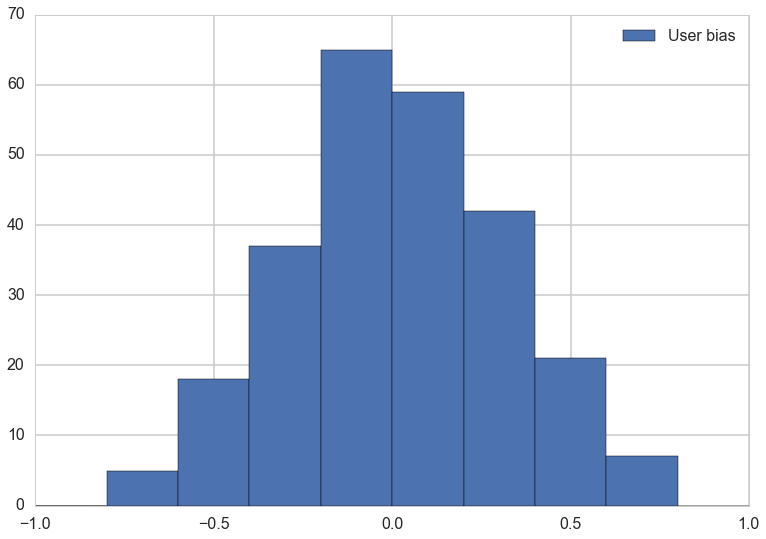

In [220]:
user_bias = user_biases.values()
mean_user_bias = np.mean(user_bias)
median_user_bias = np.median(user_bias)
plt.hist(user_bias, range=(-1,1), label="User bias");
plt.legend()

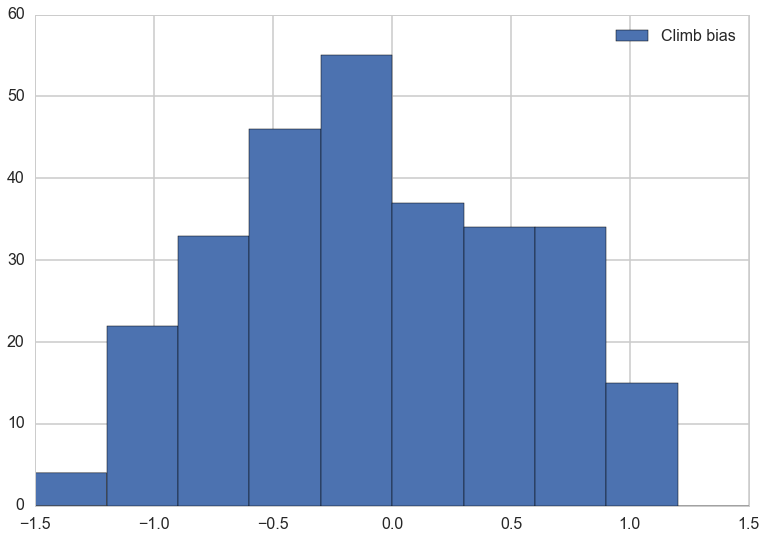

In [222]:
climb_bias = climb_biases.values()
mean_climb_bias = np.mean(climb_bias)
median_climb_bias = np.median(climb_bias)
plt.hist(climb_bias, range=(-1.5,1.5), label="Climb bias");
plt.legend()

We note the the user biases are very noramlly distributed, while the climb biases are less so.  The user biases are also a much tighter distribution.

##Create a baseline model

We can easily turn these calculations into a baseline model.

In [22]:
predictions={}
predictions_valid={}

In [23]:
predictions["baseline"] = []
for index, row in testdf.iterrows():
    user = row["user_id"]
    climb = row["climb_id"]
    prediction = ybar + (user_biases[user]) + (climb_biases[climb])
    predictions["baseline"].append(prediction)
    
predictions_valid["baseline"] = []
for index, row in validatedf.iterrows():
    user = row["user_id"]
    climb = row["climb_id"]
    prediction = ybar + (user_biases[user]) + (climb_biases[climb])
    predictions_valid["baseline"].append(prediction)

We'll borrow the compare_results function from homework 4.

In [24]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [25]:
def compare_results(stars_actual, stars_predicted, ylow=1, yhigh=6, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 's-', label="means for %s" % model)
    c=cl.get_color()

    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1, label="predicted for %s" % model)

    if not onsame:
        ax.plot([1,5],[1,5], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        ax.set_xlim([0.9, 4.1])
    ax.legend(frameon=False, loc="upper left")
    rmse=get_rmse(stars_actual, stars_predicted)
    print "RMSE for %s" % model, rmse
    return ax,rmse

RMSE for baseline 0.602627202244


(<matplotlib.axes._subplots.AxesSubplot at 0x1096eee90>, 0.60262720224436661)

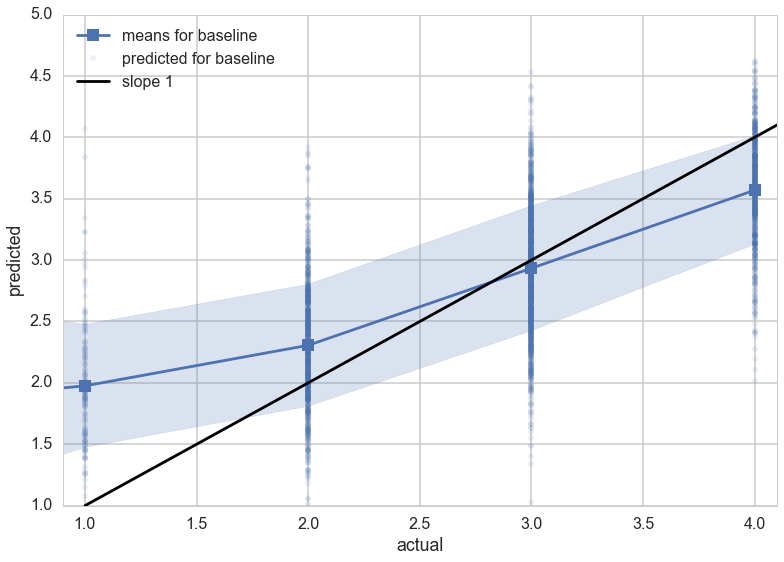

In [27]:
compare_results(testdf.star_rating, predictions['baseline'], model="baseline", predicteds=True, yhigh=5)

An RMSE of 0.603 is better than we got on homework 4, but we are working with better supported data and a 4-star instead of 5-star scale.

##Run a ridge regression with a larger feature matrix

Let's now work with some additional features, and in doing so switch to ridge regression that will help us prevent overfitting.

To create a feature matrix, we'll need the information that will become the features.

In [28]:
climbsdf = pd.read_csv("finalproject-sorted_climbs.csv")

In [29]:
climbsdf.head()

,Unnamed: 0,climb_id,climb_name,climb_link,fa_year,feet,page_views,pitches,avg_stars,grade,state,latitude,longitude,area_0,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,"type_TR,",type_aid,type_alpine,type_boulder,type_ice,type_mixed,type_sport,type_trad,guide_aid_grade,guide_boulder_grade,guide_ice_grade,guide_mixed_grade,guide_rock_grade,concensus_aid_grade,concensus_boulder_grade,concensus_ice_grade,concensus_mixed_grade,concensus_rock_grade
0,105714713,105714713,garden-party,http://www.mountainproject.com/v/garden-party/...,NaN,60,1157,1,2.0769,NaN,44.0597,-103.4232,0,/destinations/,/v/south-dakota/105708963,/v/falling-rock/105714240,/v/north-canyon-wall/105714312,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,5.8,0,0,0,0,5.8-
1,105714716,105714716,paperboy-centerfold,http://www.mountainproject.com/v/paperboy-cent...,NaN,60,1320,1,2.1333,NaN,44.0597,-103.4232,0,/destinations/,/v/south-dakota/105708963,/v/falling-rock/105714240,/v/north-canyon-wall/105714312,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,5.8,0,0,0,0,5.8
2,105714719,105714719,blockhead,http://www.mountainproject.com/v/blockhead/105...,NaN,70,1106,1,2.3529,NaN,44.0597,-103.4232,0,/destinations/,/v/south-dakota/105708963,/v/falling-rock/105714240,/v/north-canyon-wall/105714312,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,1,0,0,0,0,0,5.10,0,0,0,0,5.10
3,105714722,105714722,central-yellow-wall,http://www.mountainproject.com/v/central-yello...,NaN,20,1377,NaN,3.2857,NaN,43.8477,-103.5668,0,/destinations/,/v/south-dakota/105708963,/v/custer-state-park/106058091,/v/sylvan-lake-/106887955,/v/outlets/105714243,/v/campground-boulder/105714321,NaN,NaN,NaN,NaN,1,0,0,1,0,0,0,0,0,V3,0,0,0,0,V3,0,0,0
4,105714728,105714728,waves,http://www.mountainproject.com/v/waves/105714728,NaN,180,9063,2,3.4797,NaN,43.8864,-103.4670,0,/destinations/,/v/south-dakota/105708963,/v/mount-rushmore-national-memorial/106062228,/v/south-seas/105714249,/v/shipyard-rock/105714333,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,5.8,0,0,0,0,5.8


Let's drop any data we don't actually need.

In [30]:
mask = [True if x in trainClimbs else False for x in climbsdf.climb_id]
climbsdf = climbsdf[mask]

In [31]:
climbsdf = climbsdf[["climb_id", "pitches", "type_TR,", "type_aid", "type_alpine", "type_boulder", 
                     "type_ice", "type_mixed", "type_sport", "type_trad", "concensus_aid_grade", 
                     "concensus_boulder_grade", "concensus_ice_grade", "concensus_mixed_grade", 
                     "concensus_rock_grade"]]

And give the columns simpler names while we're at it.

In [32]:
climbsdf.columns = ["climb_id", "pitches", "tr", "aid", "alpine", "boulder", "ice", "mixed", "sport", "trad", "aid_grade", "boulder_grade", "ice_grade", "mixed_grade", "rock_grade"]

###Normalizing and consolidating difficulty grades

Let's now work towards making all the grades comparable, by first converting each to a simple number.

In [33]:
climbsdf["aid_grade_num"] = [int(x[1]) + (0.3 if len(x) > 2 and x[2] == "+" else 0) - 
                             (0.3 if len(x) > 2 and x[2] == "-" else 0) if x != "0" 
                             else float('nan') for x in climbsdf.aid_grade]
climbsdf["boulder_grade_num"] = [int(x[1]) + (0.3 if len(x) > 2 and x[2] == "+" else 0) - 
                                 (0.3 if len(x) > 2 and x[2] == "-" else 0) if x != "0" 
                                 else float('nan') for x in climbsdf.boulder_grade]
climbsdf["ice_grade_num"] = [int(x[2]) + (0.3 if len(x) > 3 and x[3] == "+" else 0) - 
                             (0.3 if len(x) > 3 and x[3] == "-" else 0) if x != "0" 
                             else float('nan') for x in climbsdf.ice_grade]
climbsdf["mixed_grade_num"] = [(int(x[1:]) if len(x) > 2 and x[2] != "+" and x[2] != "-" else int(x[1])) + 
                               (0.3 if len(x) > 2 and x[2] == "+" else 0) - 
                               (0.3 if len(x) > 2 and x[2] == "-" else 0) if x != "0" 
                               else float('nan') for x in climbsdf.mixed_grade]

In [34]:
climbsdf["rock_grade_num"] = [(float(x[2:x.find("+")]) + 0.3 if x.find("+") != -1 else
                               float(x[2:x.find("-")]) -0.3 if x.find("-") != -1 else
                               float(x[2:x.find("a/b")]) - 0.25 if x.find("a/b") != -1 else
                               float(x[2:x.find("b/c")]) if x.find("b/c") != -1 else
                               float(x[2:x.find("c/d")]) + 0.25 if x.find("c/d") != -1 else
                               float(x[2:x.find("a")]) - 0.375 if x.find("a") != -1 else
                               float(x[2:x.find("b")]) - 0.125 if x.find("b") != -1 else
                               float(x[2:x.find("c")]) + 0.125 if x.find("c") != -1 else
                               float(x[2:x.find("d")]) + 0.375 if x.find("d") != -1 else
                               float(x[2:]))
                              if x != '0' and x != '5-6' else float('nan') for x in climbsdf.rock_grade]

And we can normalize the grades in each grading system.

In [35]:
aid_mean = np.mean(climbsdf.aid_grade_num)
aid_std = np.std(climbsdf.aid_grade_num)
boulder_mean = np.mean(climbsdf.boulder_grade_num)
boulder_std = np.std(climbsdf.boulder_grade_num)
ice_mean = np.mean(climbsdf.ice_grade_num)
ice_std = np.std(climbsdf.ice_grade_num)
mixed_mean = np.mean(climbsdf.mixed_grade_num)
mixed_std = np.std(climbsdf.mixed_grade_num)
rock_mean = np.mean(climbsdf.rock_grade_num)
rock_std = np.std(climbsdf.rock_grade_num)

In [36]:
climbsdf["aid_grade_norm"] = (climbsdf.aid_grade_num - aid_mean)/aid_std
climbsdf["boulder_grade_norm"] = (climbsdf.boulder_grade_num - boulder_mean)/boulder_std
climbsdf["ice_grade_norm"] = (climbsdf.ice_grade_num - ice_mean)/ice_std
climbsdf["mixed_grade_norm"] = (climbsdf.mixed_grade_num - mixed_mean)/mixed_std
climbsdf["rock_grade_norm"] = (climbsdf.rock_grade_num - rock_mean)/rock_std

And we can move everything to one collumn using np.nanmean

In [37]:
climbsdf["norm_grade"] = climbsdf[["aid_grade_norm", "boulder_grade_norm", "ice_grade_norm", 
                                   "mixed_grade_norm", "rock_grade_norm"]].apply(np.nanmean, axis=1)

In [40]:
climbsdf["norm_grade"] = [0 if np.isnan(x) else x for x in climbsdf.norm_grade]

###Defining our feature matrix and running a ridge regression

Let's also allow for a third order fit in climb difficulty.

In [41]:
climbsdf["norm_grade_2"] = climbsdf[["norm_grade"]]**2
climbsdf["norm_grade_3"] = climbsdf[["norm_grade"]]**3

And normalize the number of pitches.

In [43]:
pitches_mean = np.mean(climbsdf.pitches)
pitches_std = np.std(climbsdf.pitches)
climbsdf["pitches_norm"] = (climbsdf.pitches - pitches_mean)/pitches_std

Our features will be the number of pitches, what type of climb it is, and the grade with a third order fit.

In [44]:
climbsdf = climbsdf[["climb_id", "pitches_norm", "tr", "aid", "alpine", "boulder", "ice", "mixed", 
                     "sport", "trad", "norm_grade", "norm_grade_2", "norm_grade_3"]]

In [45]:
climbsdict = {int(x[0]) : x[1:] for x in climbsdf.values}

Our feature matrix will have a column for each user_id (which should roughly contain the user bias information), a column for each climb_id (which should roughly contain the climb bias information), and a column for each user_id - climb feature combination (which should roughly contain each user's preferences for various features).

In [48]:
def make_feature_matrix(indf):
    num_features = len(climbsdict.values()[0])
    featurematrix = np.zeros(shape=(len(indf), len(useridmap) + len(climbidmap) + len(useridmap) * num_features))
    inarray = indf[["user_id", "climb_id", "star_rating"]].values
    for i in range(len(inarray)):
        featurematrix[i, useridmap[inarray[i,0]]] = 1
        featurematrix[i, len(useridmap) + climbidmap[inarray[i,1]]] = 1
        for i in range(num_features):
            featurematrix[i, (len(useridmap) + len(climbidmap) + useridmap[inarray[i,0]] * num_features) + i] = climbsdict[inarray[i,1]][i]
    return (featurematrix, indf.star_rating.values)

We'll create the matrices and check their shapes.

In [49]:
%%time

train_fm, train_stars = make_feature_matrix(traindf)
validate_fm, validate_stars = make_feature_matrix(validatedf)
test_fm, test_stars = make_feature_matrix(testdf)

CPU times: user 794 ms, sys: 53.2 ms, total: 847 ms
Wall time: 844 ms


In [50]:
print "Matrix Shapes:"
print 
print "train_fm", train_fm.shape
print "train_stars", train_stars.shape
print "validate_fm", validate_fm.shape
print "validate_stars", validate_stars.shape
print "test_fm", test_fm.shape
print "test_stars", test_stars.shape

Matrix Shapes:

train_fm (15537, 3583)
train_stars (15537,)
validate_fm (3306, 3583)
validate_stars (3306,)
test_fm (3374, 3583)
test_stars (3374,)


We can run this as ridge regression using Sci Kit Learn.

In [51]:
from sklearn.linear_model import Ridge

In [52]:
%%time

vdict={}
rdict={}
for alpha in [0.01, 0.1, 1, 10, 100, 1000]:
    regression = Ridge(alpha=alpha).fit(train_fm, train_stars)
    rdict[alpha] = regression
    predictions_actual_zip = zip(list(regression.predict(validate_fm)),list(validate_stars))
    se_sum = 0
    for (a,b) in predictions_actual_zip:
        se_sum = se_sum + (a - b)**2
    vdict[alpha] = np.sqrt(se_sum / len(predictions_actual_zip))

CPU times: user 1min 17s, sys: 1.7 s, total: 1min 19s
Wall time: 29.6 s


In [53]:
minerroralpha=min(vdict, key=vdict.get)
print minerroralpha
regr=rdict[minerroralpha] 

1


And we can save the results and produce another compare_results figure.

In [54]:
predictions["feature"] = list(regr.predict(test_fm))
predictions_valid["feature"] = list(regr.predict(validate_fm))

RMSE for Ridge Regression 0.570042197518


(<matplotlib.axes._subplots.AxesSubplot at 0x10be74b90>, 0.57004219751757634)

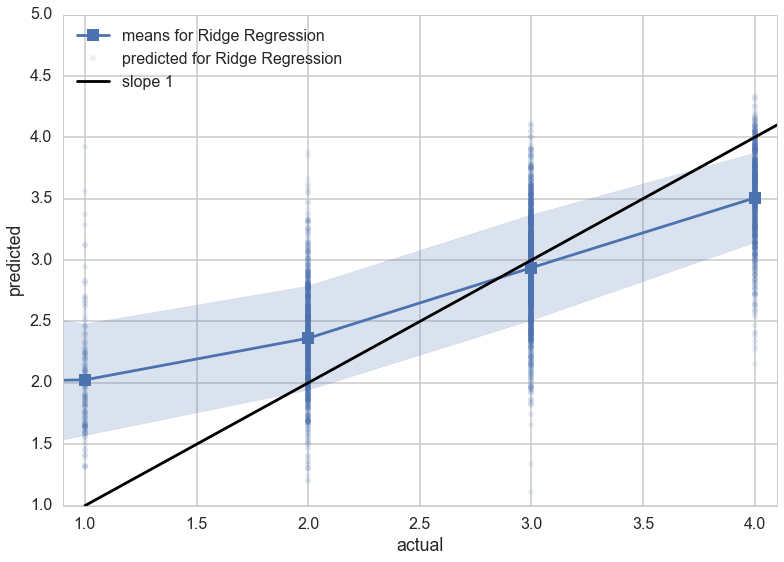

In [55]:
compare_results(test_stars, predictions["feature"], model="Ridge Regression", yhigh=5, predicteds=True)

We note a moderate improvement over the baseline model.

##K Nearest Neighbors

We'll copy this largely from homework 4.

In [56]:
users_for_climbs = traindf.groupby('climb_id').user_id.unique()
lres=len(climbids)
supports=[[[] for i in range(lres)] for i in range(lres)]
supporthistlist=[]
for i, climb1 in enumerate(climbids):
    for j, climb2 in enumerate(climbids):
        if  i <= j:#its symmetric
            if climb1 == climb2:
                common_reviewers = users_for_climbs[climb1]
            else:
                common_reviewers = set(users_for_climbs[climb1]).intersection(set(users_for_climbs[climb2]))
                supporthistlist.append(len(common_reviewers))
            supports[i][j]=common_reviewers
            supports[j][i]=common_reviewers
print "Mean and Median support is:",np.mean(supporthistlist), np.median(supporthistlist)

Mean and Median support is: 13.9563548551 12.0


In [57]:
from scipy.stats.stats import pearsonr

In [92]:
def pearson_sim(climb1_reviews, climb2_reviews, n_common):
    
    if n_common < 2:
        return 0
    
    if type(climb1_reviews) == dict:
        x = climb1_reviews.values()
    elif type(climb1_reviews) == pd.core.frame.DataFrame:
        x = [row[1] - user_biases[row[0]] for row in climb1_reviews[["user_id","star_rating"]].values.tolist()]
    else:
        return 0
    
    if type(climb2_reviews) == dict:
        y = climb2_reviews.values()
    elif type(climb2_reviews) == pd.core.frame.DataFrame:
        y = [row[1] - user_biases[row[0]] for row in climb2_reviews[["user_id","star_rating"]].values.tolist()]
    else:
        return 0
    
    return pearsonr(x,y)[0]

In [60]:
def get_climb_reviews(climb_id, df, set_of_users):
    """
    given a resturant id and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    mask = (df.user_id.isin(set_of_users)) & (df.climb_id == climb_id)
    reviews = df[mask]
    reviews = reviews[reviews.user_id.duplicated() == False]
    return reviews

In [61]:
class Database:
    "A class representing a database of similarities and common supports"
    
    def __init__(self, rindexmap, supports):
        "the constructor, takes a map of restaurant id's to integers"
        database={}
        self.rindexmap=rindexmap
        self.supports=supports
        l_keys=len(self.rindexmap.keys())
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)

    def set_supports(self, supports):
        self.supports=supports
        
    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.rindexmap[b1]][self.rindexmap[b2]]
        nsup=self.database_sup[self.rindexmap[b1]][self.rindexmap[b2]]
        return (sim, nsup)

In [62]:
db=Database(climbidmap, supports)

In [70]:
traindf.head(1)

,climb_id,user_id,star_rating
1,105717289,106192059,3


In [71]:
def mapper1(row):
    return row[2], (row[1], row[3], user_biases[row[2]] + ybar)

In [72]:
def combiner(items):
    indict={}
    for key, value in items:
        if not indict.has_key(key):
            indict[key]=[]
        indict[key].append(value)
    return indict.items()

In [73]:
def reducer1(the_input):
    user_id, values = the_input
    ratings=[]
    for climb_id,stars,user_avg in values:
        ratings.append((climb_id,(stars, user_avg)))
    return user_id, ratings

In [74]:
from itertools import combinations_with_replacement

In [75]:
def mapper2(the_input):
    user_id, the_list = the_input
    return [((a[0][0], a[1][0]),(a[0][1],a[1][1])) for a in list(combinations_with_replacement(the_list, 2))]

In [76]:
def combiner_list(itemslist):
    indict={}
    for items in itemslist:
        for key, value in items:
            if not indict.has_key(key):
                indict[key]=[]
            indict[key].append(value)
    return indict.items()

In [80]:
def reducer2(the_input):
    climbtuple, the_list = the_input
    n_common = len(the_list)
    climb1_reviews={}
    climb2_reviews={}
    for i in range(n_common):
        climb1_reviews[i] = the_list[i][0][0] - the_list[i][0][1]
        climb2_reviews[i] = the_list[i][1][0] - the_list[i][1][1]
    return (climbtuple, (pearson_sim(climb1_reviews, climb2_reviews, n_common), n_common))

In [81]:
def map_reduce(tuples):
    mapped1=map(mapper1, tuples)
    combine1=combiner(mapped1)
    reduced1=reduce(lambda x,y: x + [reducer1(y)], combine1, [])
    mapped2=map(mapper2,reduced1)
    combine2=combiner_list(mapped2)
    output=reduce(lambda x,y: x + [reducer2(y)], combine2, [])
    return output

In [82]:
%%time

tuples=traindf.itertuples()
sims=map_reduce(tuples)

CPU times: user 12.9 s, sys: 322 ms, total: 13.2 s
Wall time: 13.2 s


In [83]:
def populate_from_mr(db, df, mapredlist):
    for tpair,vpair in mapredlist:
        i1=db.rindexmap[tpair[0]]
        i2=db.rindexmap[tpair[1]]
        db.database_sim[i1][i2]=vpair[0]
        db.database_sup[i1][i2]=vpair[1]
        db.database_sim[i2][i1]=vpair[0]
        db.database_sup[i2][i1]=vpair[1]

In [84]:
populate_from_mr(db, traindf, sims)

In [94]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

In [95]:
from operator import itemgetter

In [96]:
def knearest(climb_id, set_of_climbs, dbase, k=7, reg=3.):
    """
    Given a restaurant_id, dataframe, and database, get a sorted list of the
    k most similar restaurants from the set of restaurants.
    """
    similars=[]
    for other_climb_id in set_of_climbs:
        if other_climb_id!=climb_id:
            sim, nc=dbase.get(climb_id, other_climb_id)
            ssim=shrunk_sim(sim, nc, reg=reg)
            simdist=(1. - ssim)/2.
            similars.append((other_climb_id, simdist, nc ))
    similars=sorted(similars, key=itemgetter(1))
    return similars[0:k]

In [108]:
def get_users_climbs(df, user_id):
    dfuser=df[df.user_id==user_id]
    dfuserdedup=dfuser.drop_duplicates('climb_id')
    return dict(zip(dfuserdedup.climb_id.values, dfuserdedup.star_rating.values))

In [116]:
def rating(set_of_climbs, dbase, climb_id, user_id, k=7, reg=3.):
    nearest_list = knearest(climb_id, set_of_climbs, dbase, k=k, reg=reg)
    top_sum = 0.
    bot_sum = 0.
    for triple in nearest_list:
        if not np.isnan(triple[1]):
            # If we just use the similarity distance as defined above, we'll be giving the most weight to the 
            # least correlated climbs, so we want to invert the distance scale.
            invert_dist = 1 - triple[1]
            top_sum = top_sum + invert_dist * (set_of_climbs[triple[0]] - (ybar + 
                                               user_biases[user_id] + climb_biases[triple[0]]))
            bot_sum = bot_sum + invert_dist
    #In the case there were no triples, make sure (top_sum / bot_sum) will return 0 and not something that could
    #cause errors later on
    if bot_sum == 0:
        bot_sum, top_sum = 1, 0
            
    return (ybar + user_biases[user_id] + climb_biases[climb_id]) + (top_sum / bot_sum)

In [117]:
trainuser = list(traindf.user_id)[0]
testclimb = list(testdf[testdf.user_id==trainuser].climb_id)[0]

In [118]:
rating(get_users_climbs(traindf, trainuser), db, testclimb, trainuser, k=2, reg=3.)

3.629871978356686

In [125]:
def get_ratings_user_nbd(indf, traindf, db, k=2, reg=3.):
    zips=zip(indf.climb_id, indf.user_id, indf.star_rating)
    preds=[]
    actuals=[]
    for (r,u,actual) in zips:
        pred=rating(get_users_climbs(traindf, u), db, r,u, k, reg)
        preds.append(pred)
        actuals.append(actual)
    return np.array(preds), np.array(actuals)

We randomly choose a k-reg value pair just to check that everything is working.

RMSE for knn(user) on training k=4, reg=4 0.561026221277


(<matplotlib.axes._subplots.AxesSubplot at 0x144a40f90>, 0.56102622127730062)

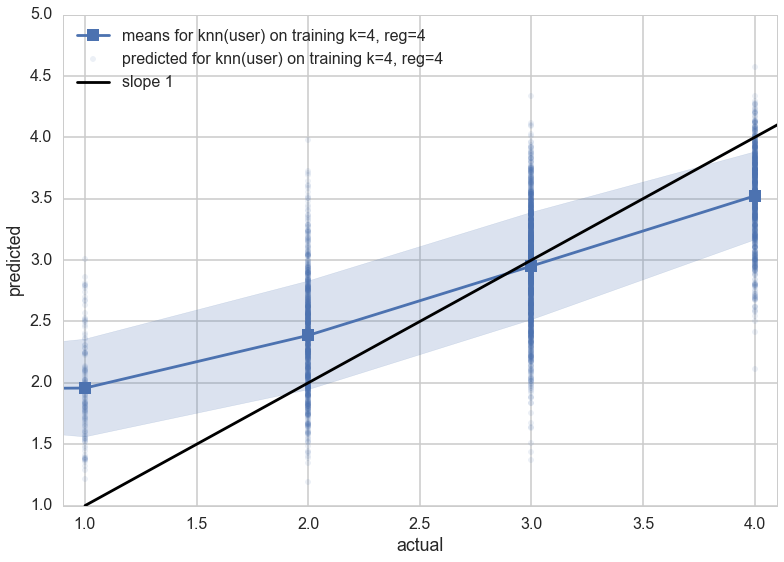

In [132]:
_, ax = plt.subplots(1, 1)
pt, at = get_ratings_user_nbd(testdf, traindf, db, k=4, reg=4.)
compare_results(at, pt, model="knn(user) on training k=4, reg=4", predicteds=True, yhigh=5, axis=ax)

And we do a grid search to optimize the k-reg choice.

In [134]:
%%time

rmsedict = {}
k_grid_1 = [4, 8, 16, 32, 64, 128]
reg_grid_1 = [0.1, 1, 10, 100, 1000]
for k in k_grid_1:
    for reg in reg_grid_1:
        pt, at = get_ratings_user_nbd(validatedf, traindf, db, k=k, reg=reg)
        _, rmse = compare_results(at, pt, model=("k=%d reg=%.1f" % (k, reg)), predicteds=True, axis=ax)
        rmsedict[(k, reg)] = rmse
min_k, min_reg = min(rmsedict, key=rmsedict.get)
print min_k, min_reg

RMSE for k=4 reg=0.1 0.618368317832
RMSE for k=4 reg=1.0 0.616357294853
RMSE for k=4 reg=10.0 0.614463061421
RMSE for k=4 reg=100.0 0.608616165393
RMSE for k=4 reg=1000.0 0.609185877343
RMSE for k=8 reg=0.1 0.586138678522
RMSE for k=8 reg=1.0 0.586321021421
RMSE for k=8 reg=10.0 0.585555518953
RMSE for k=8 reg=100.0 0.586999435823
RMSE for k=8 reg=1000.0 0.589031556821
RMSE for k=16 reg=0.1 0.571992156893
RMSE for k=16 reg=1.0 0.57140758085
RMSE for k=16 reg=10.0 0.570825210173
RMSE for k=16 reg=100.0 0.569651518599
RMSE for k=16 reg=1000.0 0.569407144554
RMSE for k=32 reg=0.1 0.562888633445
RMSE for k=32 reg=1.0 0.563073393067
RMSE for k=32 reg=10.0 0.563071331508
RMSE for k=32 reg=100.0 0.56365136737
RMSE for k=32 reg=1000.0 0.563220125122
RMSE for k=64 reg=0.1 0.560666206682
RMSE for k=64 reg=1.0 0.56064387789
RMSE for k=64 reg=10.0 0.560645315839
RMSE for k=64 reg=100.0 0.560942300893
RMSE for k=64 reg=1000.0 0.561026221277
RMSE for k=128 reg=0.1 0.56076310281
RMSE for k=128 reg=1.

In [135]:
mintup=min(rmsedict, key=rmsedict.get)

We calculate and the predictions, and create a compare_results figure.

RMSE for knn(user) for k=64, reg=1 0.570315988013


(<matplotlib.axes._subplots.AxesSubplot at 0x142dea610>, 0.57031598801285954)

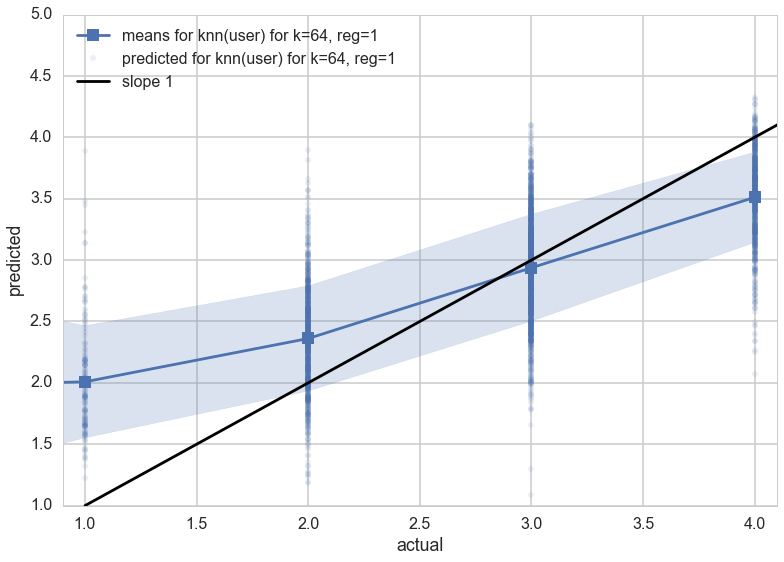

In [138]:
predictions["knn"] = [rating(get_users_climbs(traindf, user), db, climb, user, k=mintup[0], reg=mintup[1])
                      for (user, climb) in zip(list(testdf.user_id.values), list(testdf.climb_id.values))]

predictions_valid["knn"] = [rating(get_users_climbs(traindf, user), db, climb, user, k=mintup[0], reg=mintup[1])
                            for (user, climb) in zip(list(validatedf.user_id.values), list(validatedf.climb_id.values))]

pt, at = get_ratings_user_nbd(testdf, traindf, db, k=4, reg=4.)
compare_results(testdf.star_rating, predictions['knn'], model=("knn(user) for k=%d, reg=%d" % (mintup[0], mintup[1])), predicteds=True, yhigh=5)

This is an improvement over the baseline by almost exactly the same amount as the feature matrix ridge regression was an improvement.

##Create an ensemble

Let's do an ensemble to see if the feature matrix ridge regression and KKN captured different improvements and if we can leverage a combination of the two to improve our predictions.

In [140]:
dfensemble=pd.DataFrame.from_dict({'knn':predictions_valid['knn'],
                                   'feature':predictions_valid['feature'], 
                                   'baseline':predictions_valid['baseline'], 'y':validatedf.star_rating.values})

In [141]:
from sklearn.linear_model import LinearRegression

In [142]:
valreg = LinearRegression().fit(dfensemble[['baseline','knn','feature']],dfensemble[['y']])

In [143]:
valreg.coef_

array([[-0.05531176,  0.57243752,  0.47971324]])

We see a roughly even mix of the KNN predictions and the feature matrix predictions, with a slight negative coefficient on teh baseline model, all of which is pretty much as expected.

In [144]:
dfensembletest=pd.DataFrame.from_dict({'knn':predictions['knn'],
                                       'feature':predictions['feature'], 
                                       'baseline':predictions['baseline'], 'y':testdf.star_rating.values})
epreds = valreg.predict(dfensembletest[['baseline','knn','feature']]).flatten().tolist()
testactual = np.array(dfensembletest[['y']]).flatten()

RMSE for ensemble 0.57001929309


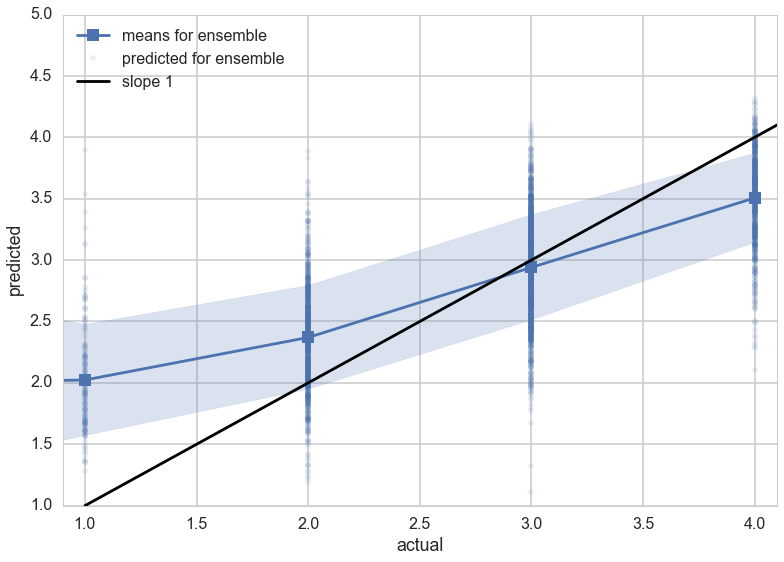

In [146]:
ax=compare_results(testactual, epreds, model="ensemble", predicteds=True, yhigh=5);

Ultimately we see essentally no improvement from the ensemble over the best of its components.

##Saving and exporting data

Let's now save the test and validation predictions.

In [163]:
import json

In [164]:
with open('predictions.json', 'w') as outfile:
    json.dump(predictions, outfile)

In [165]:
with open('predictions_valid.json', 'w') as outfile:
    json.dump(predictions_valid, outfile)

We'll also save every possible prediction (i.e. for all combinations of all users and all climbs in the dataframe).

In [166]:
all_possible = []
for climb in climbids:
    for user in userids:
        all_possible.append([climb,user])

In [170]:
allpossibledf = pd.DataFrame(all_possible, columns=['climb_id','user_id'])
allpossibledf['star_rating'] = np.zeros(len(allpossibledf))

In [171]:
allpossibledf.head()

,climb_id,user_id,star_rating
0,105717289,106192059,0
1,105717289,10232,0
2,105717289,107356939,0
3,105717289,105936209,0
4,105717289,106059834,0


In [172]:
predictions_all = {}

In [183]:
predictions_all["baseline"] = []
for index, row in allpossibledf.iterrows():
    user = row["user_id"]
    climb = row["climb_id"]
    prediction = ybar + (user_biases[user]) + (climb_biases[climb])
    predictions_all["baseline"].append(prediction)

In [174]:
all_fm, _ = make_feature_matrix(allpossibledf)
predictions_all["feature"] = list(regr.predict(all_fm))

In [175]:
predictions_all["knn"] = [rating(get_users_climbs(traindf, user), db, climb, user, k=mintup[0], reg=mintup[1])
                          for (user, climb) in zip(list(allpossibledf.user_id.values), list(allpossibledf.climb_id.values))]

In [191]:
dfensemble_all=pd.DataFrame.from_dict({'knn':predictions_all['knn'],
                                       'feature':predictions_all['feature'], 
                                       'baseline':predictions_all['baseline']})
predictions_all["ensemble"] = valreg.predict(dfensemble_all).flatten().tolist()

In [193]:
allpossibledf['baseline'] = predictions_all['baseline']
allpossibledf['feature'] = predictions_all['feature']
allpossibledf['knn'] = predictions_all['knn']
allpossibledf['ensemble'] = predictions_all['ensemble']

In [196]:
allpossibledf = allpossibledf[['climb_id', 'user_id', 'baseline', 'feature', 'knn', 'ensemble']]

In [212]:
%%time

allpossibledict = {}
for user, df in allpossibledf.groupby('user_id'):
    subdict = {}
    for _, row in df.iterrows():
        subdict.update({int(row['climb_id']): {'baseline': row['baseline'], 'feature': row['feature'], 
                                               'knn': row['knn'], 'ensemble': row['ensemble']}})
    allpossibledict.update({user: subdict})

CPU times: user 2.7 s, sys: 23.7 ms, total: 2.73 s
Wall time: 2.74 s


Let's test how this works.

In [213]:
allpossibledict[10121][105717289]

{'baseline': 3.4579616096917398,
 'ensemble': 3.2238202553305948,
 'feature': 3.1689102066910149,
 'knn': 3.313137315667622}

In [214]:
with open('predictions_all.json', 'w') as outfile:
    json.dump(allpossibledict, outfile)

Let's also create the same JSON but with climb_names and user_names instead of climb_ids and user_ids.

In [228]:
climbsdf2 = pd.read_csv("finalproject-sorted_climbs.csv")[['climb_id', 'climb_name']]

In [229]:
climbsdf2.head(1)

,climb_id,climb_name
0,105714713,garden-party


In [233]:
usersdf = pd.read_csv("finalproject-users.csv")[['user_id', 'user_name']]

In [234]:
usersdf.head(1)

,user_id,user_name
0,10101,michael-komarnitsky


In [239]:
climbsdf2['climb_name'] = [name.replace("-", " ").title() for name in climbsdf2.climb_name]

In [241]:
usersdf['user_name'] = [name.replace("-", " ").title() for name in usersdf.user_name]

In [243]:
climbsdf2.head()

,climb_id,climb_name
0,105714713,Garden Party
1,105714716,Paperboy Centerfold
2,105714719,Blockhead
3,105714722,Central Yellow Wall
4,105714728,Waves


In [245]:
usersdf.head()

,user_id,user_name
0,10101,Michael Komarnitsky
1,10102,Ben Mottinger
2,10106,Patrick Vernon
3,10107,Matt Bauman
4,10108,Quinn Stevens


In [251]:
climbIDtoName = {ID: name for idx, ID, name  in climbsdf2.itertuples()}

In [252]:
userIDtoName = {ID: name for idx, ID, name  in usersdf.itertuples()}

In [257]:
allpossibledict_names = {}
for user, dict1 in allpossibledict.iteritems():
    subdict = {}
    for climb, dict2 in dict1.iteritems():
        subdict.update({climbIDtoName[climb]: dict2})
    allpossibledict_names.update({userIDtoName[user]: subdict})

In [262]:
usernamelist = allpossibledict_names.keys()

In [268]:
climbnamelist = allpossibledict_names[usernamelist[0]].keys()

In [265]:
with open('predictions_all_names.json', 'w') as outfile:
    json.dump(allpossibledict_names, outfile)

In [266]:
with open('usernamelist.json', 'w') as outfile:
    json.dump(usernamelist, outfile)

In [269]:
with open('climbnamelist.json', 'w') as outfile:
    json.dump(climbnamelist, outfile)

##Visualizing the predictor

In [350]:
def getclimbprediction(user, climb, ax=None):
    if user not in usernamelist:
        print "Error: Eser not found.  Please enter a valid username."
    elif climb not in climbnamelist:
        print "Error: Climb not found.  Please enter a valid climb name."
    else:
        datadict = allpossibledict_names[user][climb]
        datalist = [['Baseline', datadict['baseline']], ['Feature', datadict['feature']], ['KNN', datadict['knn']], ['Ensemble', datadict['ensemble']]]
        data = pd.DataFrame(datalist)
        data.columns = ['Model', 'Prediction']
        if ax == None:
            sns.barplot(x="Model", y="Prediction", data=data)
            plt.ylim((1,4))
            plt.ylabel(("Predicted Rating"))
            plt.title(("Predictions for " + user + "'s Rating of " + climb))
        else:
            sns.barplot(x="Model", y="Prediction", data=data, ax=ax)
            ax.set_ylim((1,4))
            ax.set_ylabel(("Predicted Rating"))
            ax.set_title(("Predictions for " + user + "'s\nRating of " + climb))

In [382]:
def compareclimbpredictions(user, climblist, ax=None):
    if user not in usernamelist:
        print "Error: User not found.  Please enter a valid username."
    else:
        climblist2 = [climb for climb in climblist if climb in climbnamelist]
        if len(climblist2) == 0:
            print "Error: No valid climbs entered."
        else:
            if len(climblist2) < len(climblist):
                print "Warning:", len(climblist) - len(climblist2), "climbs not found and excluded."
            datadict = allpossibledict_names[user]
            if ax == None:
                datalist = [[climb, datadict[climb]['ensemble']] for climb in climblist2]
            else:
                datalist = [[climb[:15], datadict[climb]['ensemble']] for climb in climblist2]
            data = pd.DataFrame(datalist)
            data.columns = ['Climb', 'Prediction']
            if ax == None:
                sns.barplot(x="Climb", y="Prediction", data=data)
                plt.ylim((1,4))
                plt.ylabel(("Predicted Rating"))
                plt.title(("Comparison of " + user + "'s Predicted Ratings"))
            else:
                sns.barplot(x="Climb", y="Prediction", data=data, ax=ax)
                ax.set_ylim((1,4))
                ax.set_ylabel(("Predicted Rating"))
                ax.set_title(("Comparison of " + user + "'s Predicted Ratings"))
            

In [272]:
print usernamelist[:5]
print climbnamelist[:5]

['Chris Jd', 'Climber73', 'Randy Carmichael', 'Goodhue', 'Sean Wolf']
['Bonehead', 'Marquis De Sade', 'Prince Of Darkness', 'Deck Chairs On The Titanic', 'Edge Of Time']


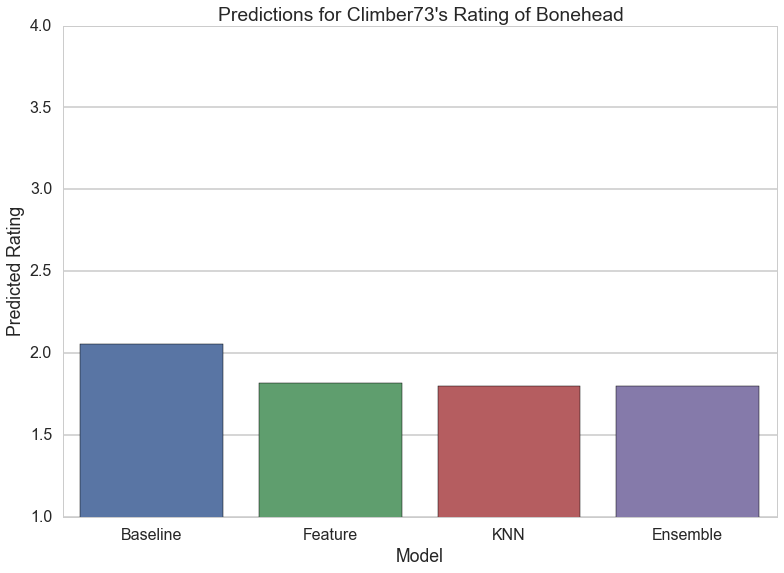

In [315]:
getclimbprediction('Climber73', 'Bonehead')

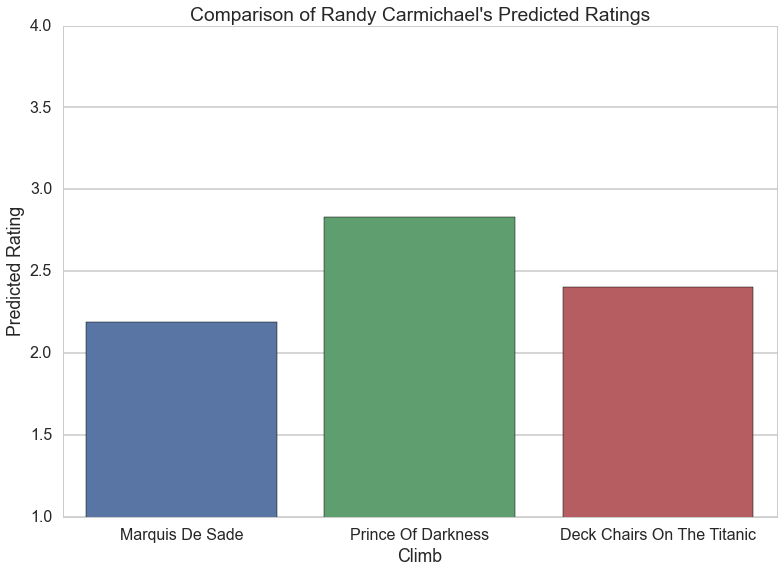

In [383]:
compareclimbpredictions('Randy Carmichael', ['Marquis De Sade', 'Prince Of Darkness', 'Deck Chairs On The Titanic'])

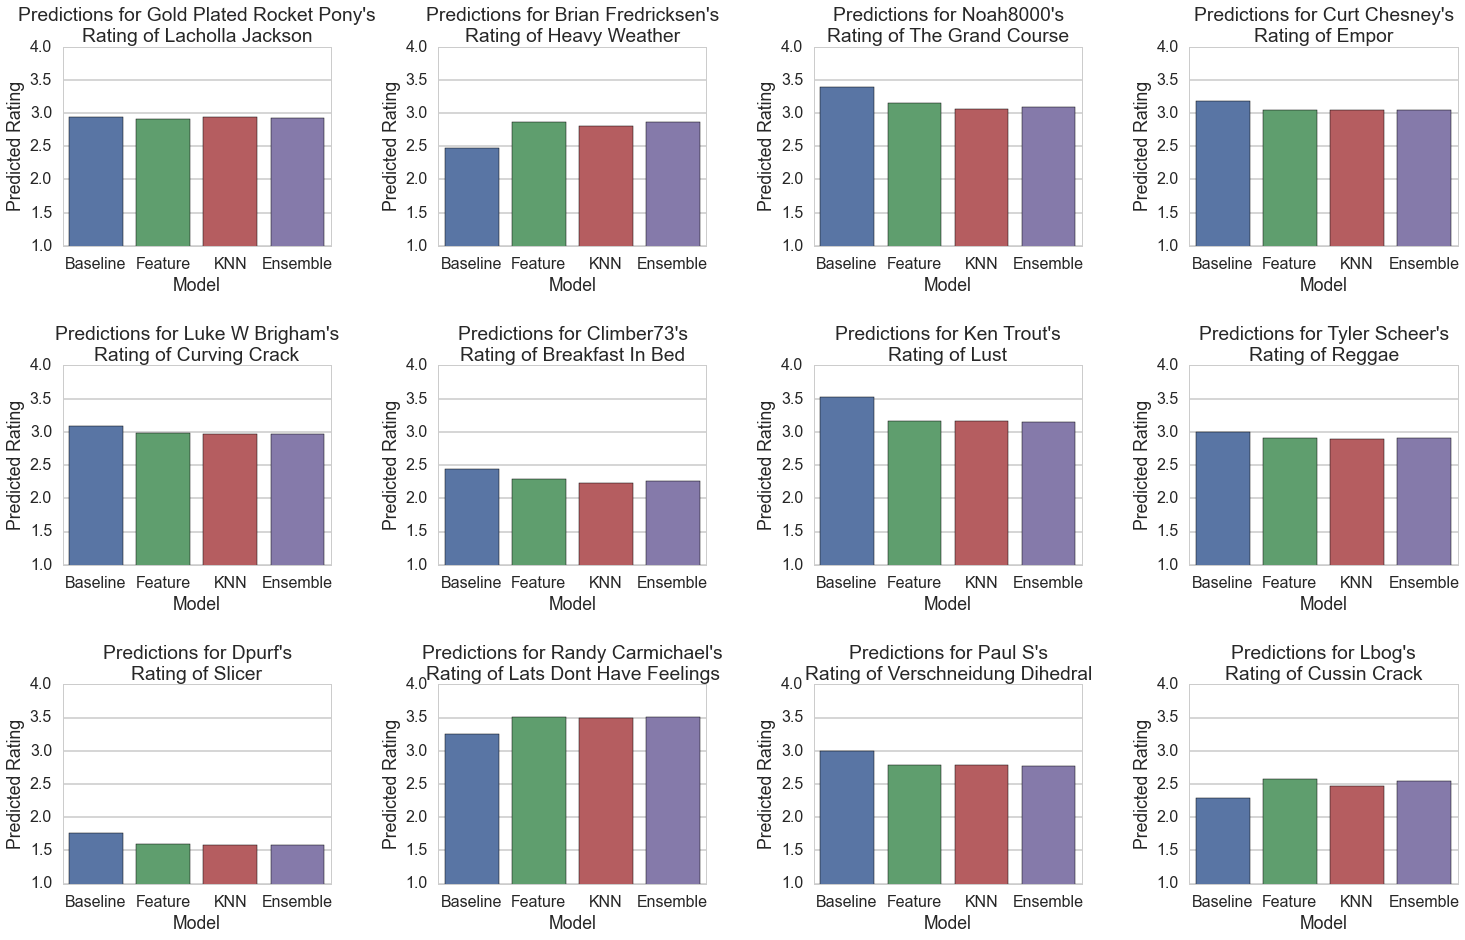

In [364]:
import random

_, ax_array = plt.subplots(3,4, figsize=(25,15))
for i in range(12):
    y, x = divmod(i,3)
    user = random.choice(usernamelist)
    climb = random.choice(climbnamelist)
    getclimbprediction(user, climb, ax=ax_array[x,y])
    plt.subplots_adjust(wspace=.4, hspace=.6)

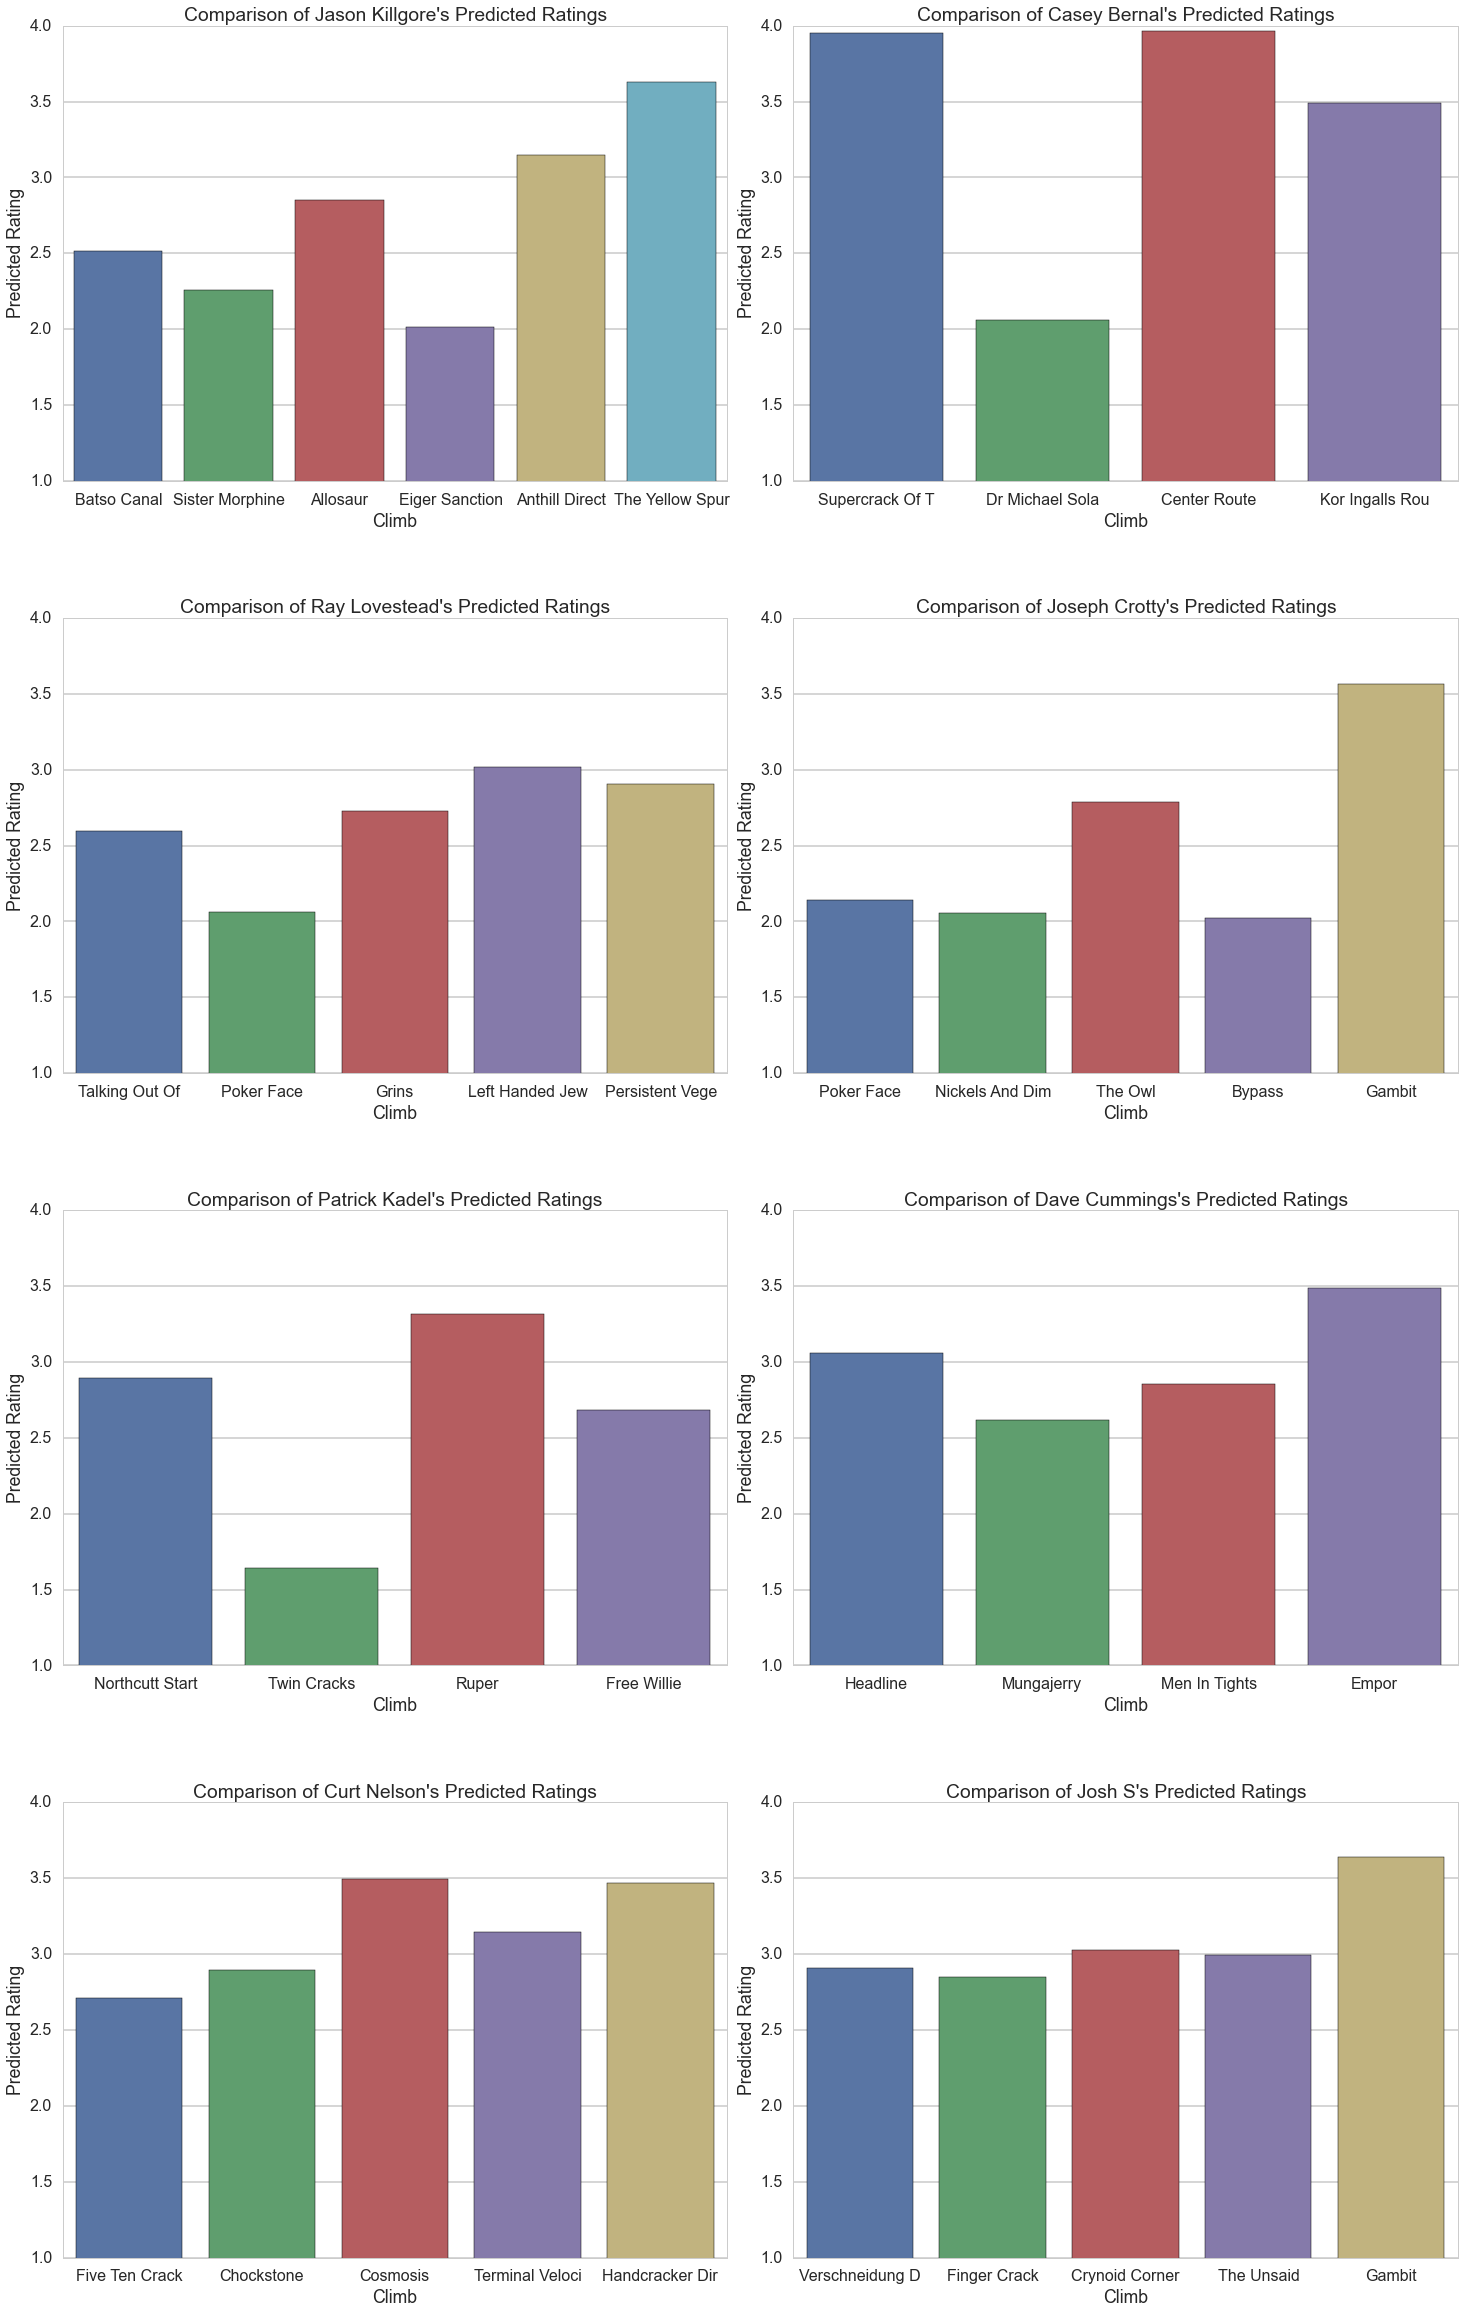

In [385]:
_, ax_array = plt.subplots(4,2, figsize=(25, 40))
for i in range(8):
    y, x = divmod(i,4)
    user = random.choice(usernamelist)
    k = random.choice(range(4, 7))
    climblist = random.sample(climbnamelist, k)
    compareclimbpredictions(user, climblist, ax=ax_array[x,y])
    plt.subplots_adjust(wspace=.1, hspace=.3)